# Business Case Study: Audiobook app
You are given data from an Audiobook app. Logically, it relates only to the audio versions of books.  We want to create a machine learning model based on our available data that can predict if a customer will buy again from the Audiobook company.

- The data is from an audiobook app, each customer in the database has make a purchase at least once.
- The main idea is that the company shouldn't spend there money targeting individuals who are unlikely to come back.
- If we focus on client who are more likely to convert again we'll get increase the sales and profitability figures.

The model must show us which are the most important metrics for a client to come back.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
columns = ["ID", "Book_length(mins)_overall", "Book_length(mins)_avg", "Price_overall", "Price_avg", 
         "Review", "Review10/10", "Completion", "Minutes_listened", "Support_Request", "Last_Visited_mins_Purchase_date", 
         "Target"]
data = pd.read_csv("data/Audiobooks_data.csv", header=None)
data.columns = columns
data.set_index('ID', drop=True, inplace=True)
data.index.name =None
data.head()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review,Review10/10,Completion,Minutes_listened,Support_Request,Last_Visited_mins_Purchase_date,Target
994,1620.0,1620,19.73,19.73,1,10.00,0.99,1603.8,5,92,0
1143,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0,0
2059,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388,0
2882,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129,0
3342,2160.0,2160,5.33,5.33,0,8.91,0.22,475.2,0,361,0


# 1. Getting aquainted with the dataset

- `ÌD`: is like a name.

- `Book_length(mins)_overall`: is the sum of the lengths of purchases.

- `Book_length(mins)_avg`: is the sum of the lengths of purchases divided by the number of purchases. Notice we don't need the number of purchases column because we ca get it from `Book_length(mins)_overall` / `Book_length(mins)_avg`.

- `Price_overall` & `Price_avg`: Same as Book length, the price variable is almost always a good predictor.

- `Review`: is boolean. It shows if the customer left a review. If so, `Review10/10` saves the review left by the user. While most users don't left a review we fill the missing reviews by avrage review column.

- `Minutes_listened`: is a measure of engagement, the total of minutes the user listen to audiobooks.

- `Completion`: is the `Minutes_listened` / `Book_length(mins)_overall`.

- `Support_Request`: Shows the total number of support request (forgotten password to assistance).

- `Last_Visited_mins_Purchase_date`: the bigger the difference, the bigger sooner the engagement. If the value is 0, we are sure the customer has never accessed what he/she has bought.

The data was gathered from the audiobook app, the input data represents `2 years` worth of engagement. We are doing supervised learning so we need `target`. We took extra `6 month` to check if the user converted or not. 1 if the customer buys in the next 6 months, 0 if the customer didn't.

- `target`: 1 if the customer bought again in the last 6 months of data. 0 if the customer did not buy again.

In [3]:
pd.set_option("display.float_format", "{:.2f}".format)
data.describe()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review,Review10/10,Completion,Minutes_listened,Support_Request,Last_Visited_mins_Purchase_date,Target
count,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00
mean,1591.28,1678.61,7.10,7.54,0.16,8.91,0.13,189.89,0.07,61.94,0.16
std,504.34,654.84,4.93,5.56,0.37,0.64,0.24,371.08,0.47,88.21,0.37
min,216.00,216.00,3.86,3.86,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1188.00,1188.00,5.33,5.33,0.00,8.91,0.00,0.00,0.00,0.00,0.00
50%,1620.00,1620.00,5.95,6.07,0.00,8.91,0.00,0.00,0.00,11.00,0.00
75%,2160.00,2160.00,8.00,8.00,0.00,8.91,0.13,194.40,0.00,105.00,0.00
max,2160.00,7020.00,130.94,130.94,1.00,10.00,1.00,2160.00,30.00,464.00,1.00


In [4]:
data.isnull().sum()

Book_length(mins)_overall          0
Book_length(mins)_avg              0
Price_overall                      0
Price_avg                          0
Review                             0
Review10/10                        0
Completion                         0
Minutes_listened                   0
Support_Request                    0
Last_Visited_mins_Purchase_date    0
Target                             0
dtype: int64

# 2. Exploratory Data Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14084 entries, 994 to 251
Data columns (total 11 columns):
Book_length(mins)_overall          14084 non-null float64
Book_length(mins)_avg              14084 non-null int64
Price_overall                      14084 non-null float64
Price_avg                          14084 non-null float64
Review                             14084 non-null int64
Review10/10                        14084 non-null float64
Completion                         14084 non-null float64
Minutes_listened                   14084 non-null float64
Support_Request                    14084 non-null int64
Last_Visited_mins_Purchase_date    14084 non-null int64
Target                             14084 non-null int64
dtypes: float64(6), int64(5)
memory usage: 1.3 MB


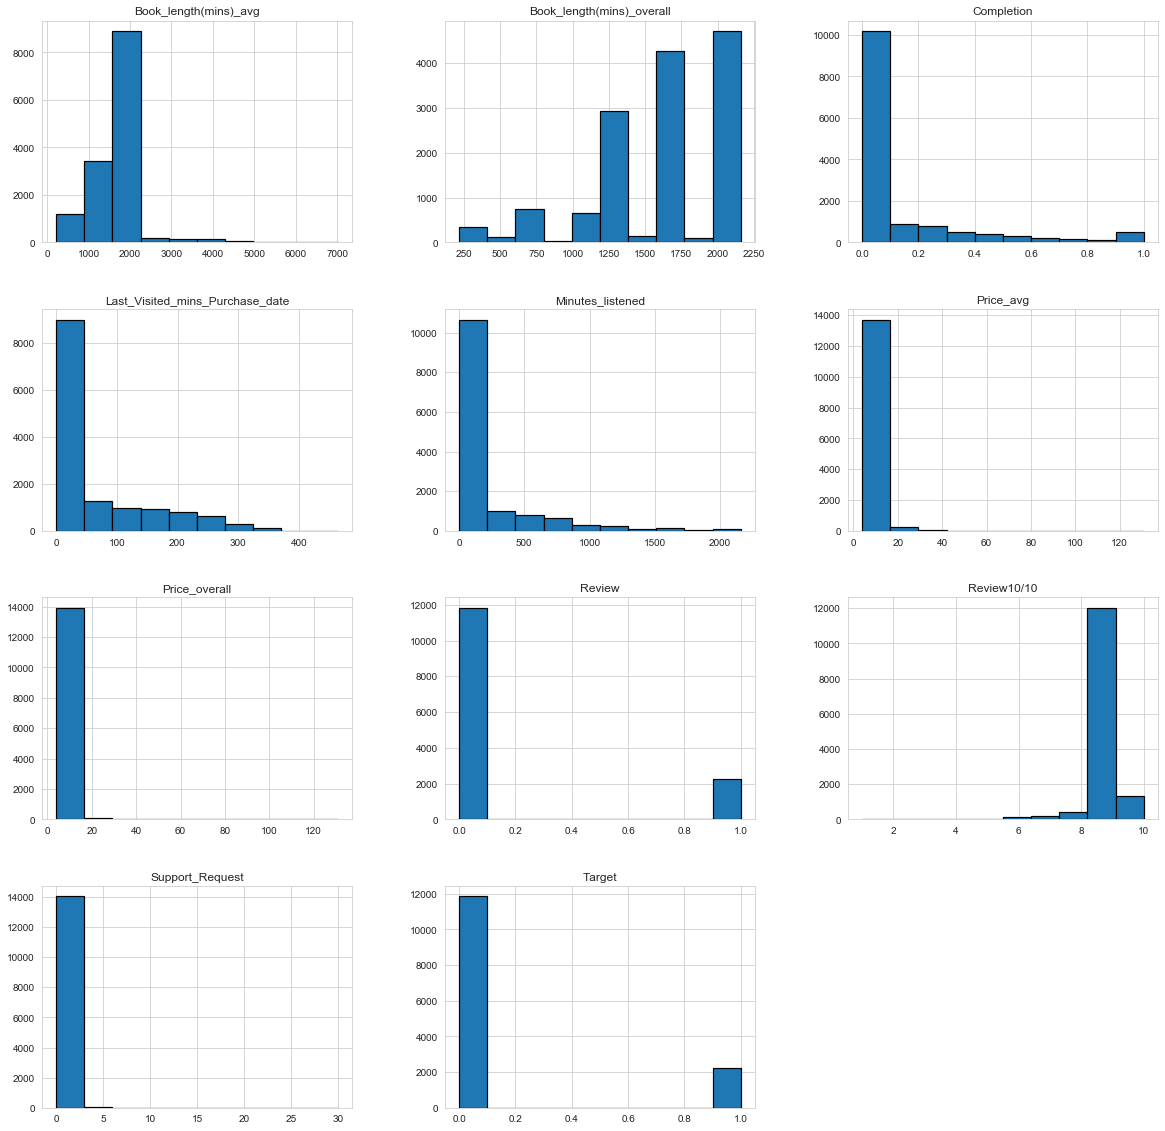

In [6]:
# Visulazing the distibution of the data for every feature
data.hist(edgecolor='black', linewidth=1.2, figsize=(20, 20));

In [7]:
print(f"{data.Target.value_counts()}")
print(f"{data.Target.value_counts()[0] / data.Target.value_counts()[1]}")

0    11847
1     2237
Name: Target, dtype: int64
5.295932051855163


It is important to notice that our `target` variable is inbabalanced. We have only `2237` user who convert again in the `6 month` period. The data need to be balanced.

In [8]:
len(list(data.columns))

11

# 3. Data Pre-processing

Since we are dealing with real life data, we will need to preprocess it a bit. This is the relevant code which is not that hard but refers to data engineering more than machine learning.

a) Handling categorical features

b) Balance the dataset. 

### a) Handling categorical features

In [9]:
data_1 = pd.get_dummies(data, columns=["Support_Request", "Review"])
data_1.head()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review10/10,Completion,Minutes_listened,Last_Visited_mins_Purchase_date,Target,Support_Request_0,...,Support_Request_4,Support_Request_5,Support_Request_6,Support_Request_7,Support_Request_8,Support_Request_10,Support_Request_12,Support_Request_30,Review_0,Review_1
994,1620.00,1620,19.73,19.73,10.00,0.99,1603.80,92,0,0,...,0,1,0,0,0,0,0,0,0,1
1143,2160.00,2160,5.33,5.33,8.91,0.00,0.00,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2059,2160.00,2160,5.33,5.33,8.91,0.00,0.00,388,0,1,...,0,0,0,0,0,0,0,0,1,0
2882,1620.00,1620,5.96,5.96,8.91,0.42,680.40,129,0,0,...,0,0,0,0,0,0,0,0,1,0
3342,2160.00,2160,5.33,5.33,8.91,0.22,475.20,361,0,1,...,0,0,0,0,0,0,0,0,1,0


In [10]:
X = data_1.drop('Target', axis=1)
y = data_1.Target

## Trying Logistic Regression without balancing the dataset

In [11]:
def accuracy_report(y_test, y_test_pred):
    print(f"=========test data============ :\n=>Accuracy Score {accuracy_score(y_test, y_test_pred)}")
    print(f"=>Confusion Matrix :\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"=>Classification Report :\n{classification_report(y_test, y_test_pred)}")

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

x_sc = StandardScaler()
X_std = x_sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [13]:
accuracy_report(y_test, y_pred)

=========test data============ :
=>Accuracy Score 0.9034433794817182
=>Confusion Matrix :
[[2358   30]
 [ 242  187]]
=>Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2388
           1       0.86      0.44      0.58       429

    accuracy                           0.90      2817
   macro avg       0.88      0.71      0.76      2817
weighted avg       0.90      0.90      0.89      2817



In [14]:
scores = cross_val_score(model, X_std, y, cv=10)
scores.mean()

0.9006674525577527

## Trying Logistic Regression with balanced dataset

Imbalanced classes put “accuracy” out of business. This is a surprisingly common problem in machine learning (specifically in classification), occurring in datasets with a disproportionate ratio of observations in each class.

Standard accuracy no longer reliably measures performance, which makes model training much trickier.

In our case we have `11847` clients who left the app and only `2237` clients who conveert again. That means if we predict that all the client have left the app we'll have an accuracy of `84.11%` ???.

In [29]:
11847 / (11847 + 2237)

0.8411672820221529

### 1. Up-sample Minority Class

Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

There are several heuristics for doing so, but the most common way is to simply resample with replacement.

In [15]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data[data.Target==0]
df_minority = data[data.Target==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=11847,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
X = df_upsampled.drop('Target', axis=1)
y = df_upsampled.Target
# Display new class counts
df_upsampled.Target.value_counts()

1    11847
0    11847
Name: Target, dtype: int64

In [16]:
x_sc = StandardScaler()
X_std = x_sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [17]:
accuracy_report(y_test, y_pred)

=========test data============ :
=>Accuracy Score 0.7963705423085039
=>Confusion Matrix :
[[2128  256]
 [ 709 1646]]
=>Classification Report :
              precision    recall  f1-score   support

           0       0.75      0.89      0.82      2384
           1       0.87      0.70      0.77      2355

    accuracy                           0.80      4739
   macro avg       0.81      0.80      0.79      4739
weighted avg       0.81      0.80      0.79      4739



Great, now the model is no longer predicting just one class. While the accuracy also took a nosedive, it's now more meaningful as a performance metric.

### 2. Down-sample Majority Class

Down-sampling involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm.

The most common heuristic for doing so is resampling without replacement.

In [30]:
# Separate majority and minority classes
df_majority = data[data.Target==0]
df_minority = data[data.Target==1]
 
# Down-sample majority class
df_majority_downsample = resample(df_majority, replace=False,     # sample with replacement
                                  n_samples=2237,    # to match minority class
                                  random_state=123) # reproducible results
 
# Combine majority class with Down-sample majority class
df_upsampled = pd.concat([df_majority_downsample, df_minority])
 
X = df_upsampled.drop('Target', axis=1)
y = df_upsampled.Target
# Display new class counts
df_upsampled.Target.value_counts()

1    2237
0    2237
Name: Target, dtype: int64

In [31]:
x_sc = StandardScaler()
X_std = x_sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [32]:
accuracy_report(y_test, y_pred)

=========test data============ :
=>Accuracy Score 0.8055865921787709
=>Confusion Matrix :
[[404  55]
 [119 317]]
=>Classification Report :
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       459
           1       0.85      0.73      0.78       436

    accuracy                           0.81       895
   macro avg       0.81      0.80      0.80       895
weighted avg       0.81      0.81      0.80       895



### 3. Change Your Performance Metric

So far, we've looked at two ways of addressing imbalanced classes by resampling the dataset. Next, we'll look at using other performance metrics for evaluating the models.

Albert Einstein once said, "if you judge a fish on its ability to climb a tree, it will live its whole life believing that it is stupid." This quote really highlights the importance of choosing the right evaluation metric.

other performance metrics to consider are `confusion_matrix`, `precision`, `recall`, and `f1-score`.

### 4. Use Tree-Based Algorithms

The final tactic we'll consider is using tree-based algorithms. Decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes.

In modern applied machine learning, tree ensembles (Random Forests, Gradient Boosted Trees, etc.) almost always outperform singular decision trees.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = data_1.drop('Target', axis=1)
y = data_1.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {'max_depth':[3, None], 'min_samples_split':[2, 3, 10], 
              'min_samples_leaf':[1, 3, 10], 'bootstrap':[True, False], 
              'criterion':["gini", "entropy"]}

random_forest_grid = GridSearchCV(model, param_grid, scoring="accuracy", 
                                  n_jobs=-1, verbose=1, cv=3, iid=True)

random_forest_grid.fit(X_train, y_train)

y_train_pred = random_forest_grid.predict(X_train)
y_test_pred = random_forest_grid.predict(X_test)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.4min finished


In [36]:
accuracy_report(y_test, y_test_pred)

=========test data============ :
=>Accuracy Score 0.9158679446219382
=>Confusion Matrix :
[[2372   16]
 [ 221  208]]
=>Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2388
           1       0.93      0.48      0.64       429

    accuracy                           0.92      2817
   macro avg       0.92      0.74      0.79      2817
weighted avg       0.92      0.92      0.90      2817



In [37]:
accuracy_report(y_train, y_train_pred)

=========test data============ :
=>Accuracy Score 0.9199431969468359
=>Confusion Matrix :
[[9435   24]
 [ 878  930]]
=>Classification Report :
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9459
           1       0.97      0.51      0.67      1808

    accuracy                           0.92     11267
   macro avg       0.94      0.76      0.81     11267
weighted avg       0.92      0.92      0.91     11267

